In [1]:
from car_racing import CarRacing
!python --version

Python 3.7.0


In [1]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

^C


In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor

gymlogger.set_level(30)
import glob
import io
import os
import cv2
import base64
from collections import deque
from datetime import datetime
import time
import torch

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

from merger import MultiCarRacing

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
gym.register(
    id='MultiCarRacing-v0',
    entry_point='merger:MultiCarRacing',
    max_episode_steps=1000,
    reward_threshold=900
)

gym.register(
    id='CarRacingDiscrete-v0',
    entry_point='merger:CarRacingDiscrete',
    max_episode_steps=1000,
    reward_threshold=900
)


In [4]:
env = gym.make('MultiCarRacing-v0', num_agents=1)
env_2 = gym.make('CarRacingDiscrete-v0')
print("Observation Space Size: ", env_2.observation_space)
print("Action Space Size: ", env_2.action_space)
print("Observation Space Size: ", env.observation_space)
print("Action Space Size: ", env.action_space)
env.close()

Observation Space Size:  Box(96, 96, 3)
Action Space Size:  Discrete(5)
Observation Space Size:  Box(96, 96, 3)
Action Space Size:  Discrete(5)


In [4]:
from stable_baselines3.common.callbacks import BaseCallback
import time
import numpy as np  # Ensure numpy is imported


class ProgressCallback(BaseCallback):
    """
    A custom callback that displays training progress, tracks the best mean reward,
    and automatically saves the model every 10 log intervals.

    Args:
        total_timesteps (int): The total number of timesteps in the training run.
        log_interval (int): The interval (in timesteps) at which to log progress.
        save_path (str): The path to save the model (this file will be overwritten each time).
        verbose (int): Verbosity level (0: no output, 1: default output).
    """

    def __init__(self, total_timesteps, log_interval=1000, save_path="model", verbose=1):
        super(ProgressCallback, self).__init__(verbose)
        self.start_time = time.time()
        self.total_timesteps = total_timesteps
        self.current_timesteps = 0
        self.episode_rewards = []
        self.log_interval = log_interval
        self.best_mean_reward = -np.inf
        self.save_path = save_path

    def _on_step(self) -> bool:
        self.current_timesteps += 1

        try:  # Try to access the reward; if it fails, it's likely the last step of training.
            reward = self.locals["rewards"][0]
            self.episode_rewards.append(reward)
        except Exception as e:
            if self.verbose > 0:
                print(e)
            pass  # Ignore the exception if reward isn't available (likely end of training).

        if self.n_calls % self.log_interval == 0:
            elapsed_time = time.time() - self.start_time
            remaining_timesteps = self.total_timesteps - self.current_timesteps

            if self.current_timesteps > 0:
                remaining_time = elapsed_time * (remaining_timesteps / self.current_timesteps)
            else:
                remaining_time = 0

            remaining_time_hours = int(remaining_time // 3600)
            remaining_time_minutes = int((remaining_time % 3600) // 60)
            remaining_time_seconds = int(remaining_time % 60)

            elapsed_time_hours = int(elapsed_time // 3600)
            elapsed_time_minutes = int((elapsed_time % 3600) // 60)
            elapsed_time_seconds = int(elapsed_time % 60)

            mean_reward = np.mean(self.episode_rewards) if self.episode_rewards else None
            self.episode_rewards = []

            print(f"Timesteps: {self.current_timesteps}/{self.total_timesteps}, "
                  f"Remaining Timesteps: {remaining_timesteps}, "
                  f"Elapsed Time: {elapsed_time_hours:02}:{elapsed_time_minutes:02}:{elapsed_time_seconds:02}, "
                  f"Estimated Time Remaining: {remaining_time_hours:02}:{remaining_time_minutes:02}:{remaining_time_seconds:02}")

            if mean_reward is not None:
                print(f"Mean Reward (last {self.log_interval} steps): {mean_reward:.5f}")

                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    print(f"New best mean reward: {self.best_mean_reward:.5f}")

            # Save the model every 10 log intervals (log_interval * 10)
            if self.n_calls % (self.log_interval * 10) == 0:
                if self.model is not None:
                    self.model.save(self.save_path)
                    print(f"Model saved to {self.save_path} (overwritten)")

        return True


In [5]:
class MonitorCustom(gym.wrappers.Monitor):
    def __init__(self, env):
        super(MonitorCustom, self).__init__(env, './video', force=True)

In [6]:
from stable_baselines3 import DQN, PPO
from stable_baselines3.dqn import CnnPolicy
from merger import CarRacingDiscrete, MultiCarRacing
import gym
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env

VERSION = "1M"
NUM_OF_STEPS = 1_000_000
LOG_INTERVAL = 1000
# BUFFER_SIZE = 150000
LEARNING_STARTS = 5000
MODEL_SAVE_NAME = "PPO_Discrete_RL_" + str(VERSION)
SAVED_MODEL_VERSION = "latest"
LOAD_SAVED_MODEL = False

env = gym.make("MultiCarRacing-v0",
               num_agents=1, verbose=0, use_ego_color=True,
               )

env = MonitorCustom(env)

# if LOAD_SAVED_MODEL:
#     try:
# 
#         PPOmodel = PPO.load(MODEL_SAVE_NAME, env=env)
#         print("LOAD SAVED PPΟ MODEL")
# 
#     except:
#         print("NO MODEL FOUND")
# else:
#     if 'PPOmodel' not in globals():
#         PPOmodel = PPO('CnnPolicy', env, verbose=1, ent_coef=0.005)
#         print("INITIALIZE NEW PPO Discrete MODEL")
#     else:
PPOmodel = PPO.load("PPO_Discrete_RL_2M.zip", env=env)

print("CONTINUE PPO Discrete MODEL TRAINING")

progress_callback = ProgressCallback(total_timesteps=NUM_OF_STEPS, verbose=1, save_path="TRAIN_PPO_Discrete_RL_" + str(VERSION))

PPOmodel.learn(total_timesteps=NUM_OF_STEPS, log_interval=LOG_INTERVAL, callback=progress_callback)
PPOmodel.save(MODEL_SAVE_NAME)

NameError: name 'MonitorCustom' is not defined

In [6]:
def evaluate_version(model, env, version_name, video_path):
    MODEL_SAVE_NAME = version_name

    try:
        loaded_model = model.load(MODEL_SAVE_NAME)
        print(f"Model {MODEL_SAVE_NAME} loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    env = MonitorCustom(env)
    obs = env.reset()
    print("Observation shape: ", obs.shape)
    done = False

    while not done:
        obs = np.copy(obs)

        action, _states = loaded_model.predict(obs, deterministic=True)

        obs, reward, done, info = env.step(action)

    env.close()

In [9]:
from stable_baselines3 import DQN, PPO
from merger import CarRacingDiscrete, MultiCarRacing
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import WarpFrame

# env = CarRacingDiscrete()
# evaluate_version(DQN, env, "DQN_RL_54", "v28", "./video")

# env_str = "MultiCarRacing-v0"
# env_kwargs_dict = {"num_agents": 1, "verbose": 0}

# env_eval = make_vec_env(env_str, n_envs=1, env_kwargs=env_kwargs_dict, wrapper_class=WarpFrame)
# env_eval = VecFrameStack(env_eval, n_stack=4)
# env_eval = VecTransposeImage(env_eval)

env = gym.make('MultiCarRacing-v0', num_agents=1, 
               use_ego_color=True)
evaluate_version(PPO, env, "PPO_Discrete_RL_2M", "./video")

Model PPO_Discrete_RL_2M loaded successfully
Track generation: 1137..1422 -> 285-tiles track
Observation shape:  (96, 96, 3)


Evaluating model...
Track generation: 1002..1263 -> 261-tiles track
Track generation: 1024..1284 -> 260-tiles track
Track generation: 1061..1338 -> 277-tiles track
Track generation: 1048..1320 -> 272-tiles track
Track generation: 1261..1580 -> 319-tiles track
Track generation: 1310..1642 -> 332-tiles track
Track generation: 1130..1417 -> 287-tiles track
Track generation: 1098..1381 -> 283-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1227..1538 -> 311-tiles track
Track generation: 1072..1344 -> 272-tiles track
Track generation: 1140..1429 -> 289-tiles track
Track generation: 1194..1513 -> 319-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1085..1360 -> 275-tiles track
Track generation: 1175..1473 -> 298-tiles track
Track generation: 1131..1418 -> 287-tiles track
Track generation: 1075..1336 -> 261-tiles track
retry to generate track (normal if there are not many of this messag

Exception ignored in: <function Viewer.__del__ at 0x000001A89595E730>
Traceback (most recent call last):
  File "D:\Programming\IUT\rl-carracing\.venv\lib\site-packages\gym\envs\classic_control\rendering.py", line 162, in __del__
    self.close()
  File "D:\Programming\IUT\rl-carracing\.venv\lib\site-packages\gym\envs\classic_control\rendering.py", line 81, in close
    self.window.close()
  File "D:\Programming\IUT\rl-carracing\.venv\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "D:\Programming\IUT\rl-carracing\.venv\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000001A8E70D37C8; to 'Win32Window' at 0x000001A8E4B8CF60>,)


Track generation: 1108..1389 -> 281-tiles track
Track generation: 992..1246 -> 254-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1212..1519 -> 307-tiles track
Track generation: 1055..1323 -> 268-tiles track
Track generation: 1099..1386 -> 287-tiles track
Track generation: 1212..1529 -> 317-tiles track
Track generation: 1235..1548 -> 313-tiles track
Track generation: 1181..1481 -> 300-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1053..1320 -> 267-tiles track
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1266..1596 -> 330-tiles track
Track generation: 1157..1450 -> 293-tiles track
Track generation: 1179..1478 -> 299-tiles track
Total evaluation time: 913.81 seconds


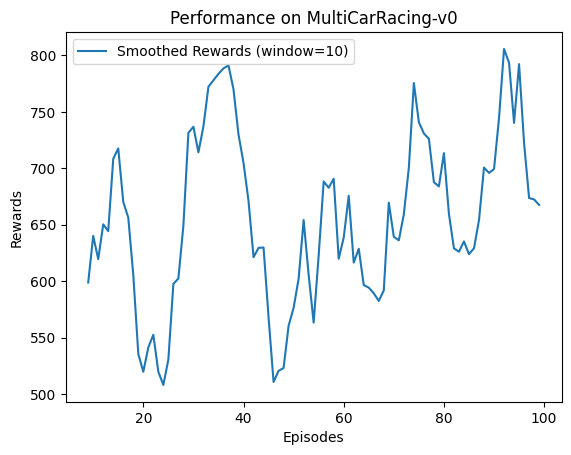

In [7]:
import pandas as pd
from stable_baselines3 import PPO


model = PPO.load("PPO_Discrete_RL_2M")

env = gym.make('MultiCarRacing-v0', num_agents=1)

num_episodes = 100

episode_rewards = []

start_time = time.time()

print("Evaluating model...")

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_rewards = 0

    while not done:
        obs = np.copy(obs)
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_rewards += reward

    episode_rewards.append(total_rewards)

end_time = time.time()
evaluation_time = end_time - start_time
print(f"Total evaluation time: {evaluation_time:.2f} seconds")

episode_rewards = np.array(episode_rewards)

window_size = 10
rewards_smoothed = pd.Series(episode_rewards).rolling(window=window_size).mean()

plt.figure()
plt.plot(rewards_smoothed, label=f'Smoothed Rewards (window={window_size})')

plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title(f"Performance on {env.spec.id}")
plt.legend()
plt.show()